# Bitcoin Price Prediction using Deep Learning Techniques

This notebook holds all experiments for the paper [insert name here](insert-link-here)

---

### Authors
 - Author1
 - Author2
 - Author3
    
### Date Created: 2024-04-22
### Date Last Modified: 2024-04-22

In [1]:
!nvidia-smi

Tue Apr 23 14:53:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P0              N/A /  60W |      8MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# We intend to shut down all warnings, and non-essential information in this notebook from TensorFlow
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

from typing import List, Tuple, Dict

In [4]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [5]:
# Checking the version of TensorFlow
print(tf.__version__)

2.15.0


## Dataset Preparation

In [6]:
dataframe = pd.read_csv('data/BTC-USD.csv', parse_dates=['Date'], index_col='Date')
dataframe.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [7]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3505 entries, 2014-09-17 to 2024-04-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3505 non-null   float64
 1   High       3505 non-null   float64
 2   Low        3505 non-null   float64
 3   Close      3505 non-null   float64
 4   Adj Close  3505 non-null   float64
 5   Volume     3505 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 191.7 KB


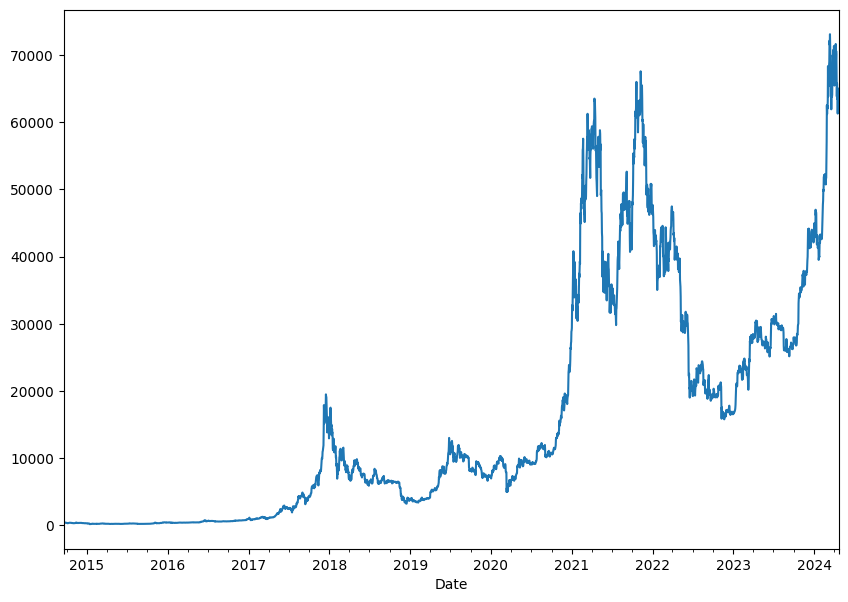

In [8]:
dataframe['Close'].plot(figsize=(10, 7));

In [9]:
# `btcc_prices` denotes the closing prices of BTC-USD.
btcc_prices = pd.DataFrame(dataframe["Close"].values, columns=["Price"], index=dataframe.index)
btcc_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [10]:
prices = btcc_prices['Price'].to_numpy()
prices

array([  457.334015,   424.440002,   394.79599 , ..., 63843.570313,
       64994.441406, 64773.386719])

In [11]:
# Normalizing the data
scaler = MinMaxScaler()

prices_normal = scaler.fit_transform(prices.reshape(-1, 1))
prices_normal

array([[0.00383005],
       [0.00337886],
       [0.00297225],
       ...,
       [0.87326138],
       [0.88904719],
       [0.88601512]])

In [12]:
# Create a plotting function
def plot_time_series(timestamps: List, values: List, format="-", start=0, end=None, title=None,
                     yLabel='BTC USD Close') -> None:
    """
    Plots a series of timestamps against values.

    Parameters
    ----------
    timestamps : list
        list of timestamp values
    values : list
        list of values across time
    format : str
        style of plot, default "."
    start : int
        starting index of the plot, ``start < len(timestamps)``
    end : int
        ending index of the plot, ``end < len(timestamps)``
    title : str
        label to show on plot of values
    """

    plt.plot(timestamps[start:end], values[start:end], format, label=title)
    plt.xlabel('Time')
    plt.ylabel(yLabel)
    if title:
        plt.legend(fontsize=14)
    plt.grid(True)


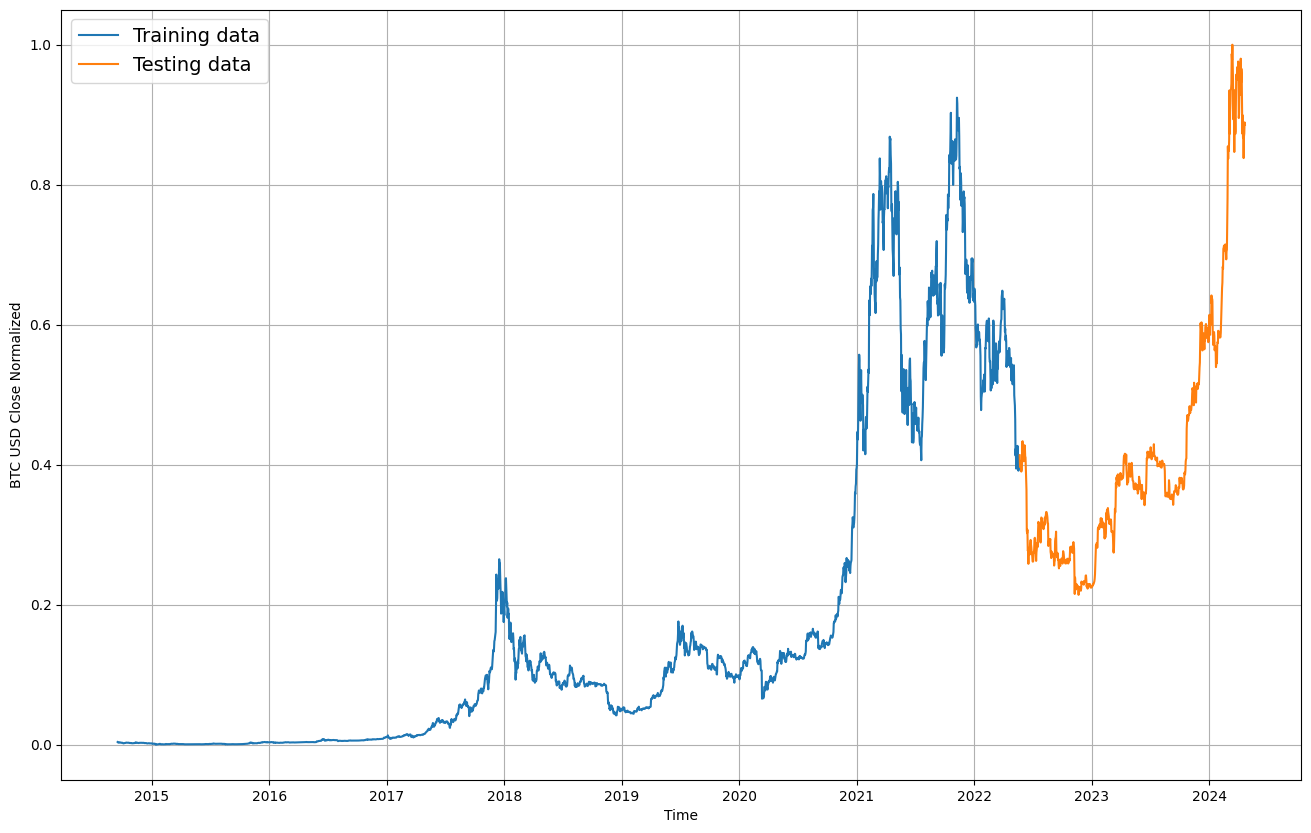

In [13]:
timestamps = btcc_prices.index.to_numpy()
training_data_len = int(.8 * len(btcc_prices))
test_data_len = len(btcc_prices) - training_data_len

plt.figure(figsize=(16, 10))
plot_time_series(timestamps=timestamps[:training_data_len], values=prices_normal[:training_data_len],
                 title="Training data")
plot_time_series(timestamps=timestamps[-test_data_len:], values=prices_normal[-test_data_len:], title="Testing data",
                 yLabel='BTC USD Close Normalized')

## Evaluation Metrics

In [14]:
def evaluate_pred(y_true: List, y_pred: List) -> Dict:
    """
    Performs various evaluation comparison functions on y_true labels and y_pred labels.

    Parameters
    ----------
    y_true : List
        true values
    y_pred : List
        predicted values

    Returns
    -------
    errors : dict
        dictionary containing the evaluation metrics, each metric is defined as a key-value pair where the key is the acronym for the metric in lowercase English.
    """
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)

    metric_results = {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
    }
    return metric_results

## Create Windows

In [15]:
WINDOW_SIZE = 7
HORIZON = 1

In [16]:
def get_labelled_windows(x: List, horizon=HORIZON) -> Tuple:
    """
    Creates labels for windowed dataset.

    E.g. if horizon=1 (default)
    Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [17]:
def make_windows(x: List, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array of sequential data into a 2D array of windowed data.

    E.g.
    x before windowing: [1, 2, 3, 4, 5, 6, 7, 8] size = (8),
    x after windowing: [[1, 2, 3, 4, 5], [2, 3, 4, 5, 6], [3, 4, 5, 6, 7]] size = (3, 5)
    """

    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)
    window_indices = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T
    windowed_array = x[window_indices]
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return tf.squeeze(windows), tf.squeeze(labels)

In [18]:
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.

    E.g. if len(windows) = 100, len(labels) = 100 and test_split = 0.2
    80 windows and labels will go to the training set and 20 will go to the test set.
    """
    split_size = int(len(windows) * (1 - test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

## Prepare Utilities for Training

In [19]:
# Create a Checkpoint & EarlyStopping callback

def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_path, model_name),
        verbose=0,
        save_best_only=True,
    )


def create_early_stopping(patience=3):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        restore_best_weights=True,
        verbose=1,
    )

## Model Experiments

1. FNN (Feed-forward, Densely Connected Network)
2. LSTM (Long Short-Term Memory)
3. Bi-LSTM (Bidirectional Long Short-Term Memory)
4. GRU (Gated Recurrent Unit)
5. Bi-GRU (Bidirectional Gated Recurrent Unit)
6. Conv1D (1-Dimensional Convolutional Neural Network)
7. N-BEATS (Neural Basis Expansion Analysis Time Series Model)

Each model will be trained and validated on the following window sizes and horizons:
- Window Size: 7, Horizon: 1
- Window Size: 7, Horizon: 7
- Window Size: 30, Horizon: 1
- Window Size: 30, Horizon: 7
- Window Size: 90, Horizon: 1
- Window Size: 90, Horizon: 7
- Window Size: 90, Horizon: 30

In [20]:
def fit_eval(
        model: tf.keras.models.Model,
        horizon=HORIZON,
        window=WINDOW_SIZE,
        epochs=100,
        fit_verbose=0,
) -> Tuple[List, Dict]:
    """
    Creates sliding windows for the given `WINDOW_SIZE` and `HORIZON`.
    Compiles and fits the model on the data for given number of `epochs`.
    Returns a dictionary of evaluation metrics.

    :param model: tf.keras.models.Model: the model to compile and fit
    :param horizon: int: the number of steps into the future to predict
    :param window: int: the number of timestamps to include in the input window
    :param epochs: int
    :param fit_verbose: int: level of verbosity of the fit method
    :return: a tuple containing the de-normalized predictions and a dictionary of evaluation metrics
    """

    # Clone the model to ensure a fresh copy is used
    model_clone = tf.keras.models.clone_model(model)
    train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
        *make_windows(
            prices_normal,
            window_size=window,
            horizon=horizon,
        ))

    model_clone.build(input_shape=(None, window))

    model_clone.add(tf.keras.layers.Dense(horizon, activation="linear"))

    model_clone.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["mae", "mse", "mape"])

    history = model_clone.fit(
        train_windows,
        train_labels,
        epochs=epochs,
        batch_size=128,
        validation_data=(test_windows, test_labels),
        callbacks=[
            create_model_checkpoint(model_name=model_clone.name + "W" + str(window) + "H" + str(horizon)),
            create_early_stopping(patience=8)
        ],
        verbose=fit_verbose,
    )

    pd.DataFrame({"Validation MAPE": history.history['val_mape']}).plot(title="Validation MAPE", figsize=(8, 6))

    print("\n" + "-" * 20 + "\nEvaluating model on test data...")
    print(model_clone.evaluate(test_windows, test_labels, verbose=0))

    model_preds = model_clone.predict(test_windows)
    test_labels_inv = scaler.inverse_transform(tf.reshape(test_labels, shape=(-1, 1)))
    model_preds_inv = scaler.inverse_transform(tf.reshape(model_preds, shape=(-1, 1)))
    model_res = evaluate_pred(y_true=test_labels_inv, y_pred=model_preds_inv)

    return model_preds_inv, model_res


In [21]:
def save_model_plot(model: tf.keras.Model):
    """
    Saves the TF Model and a plot of the model to the filesystem.
    :param model:
    :return:
    """
    tf.keras.saving.save_model(model, os.path.join("model_experiments", model.name))
    tf.keras.utils.plot_model(
        model,
        show_shapes=True,
        show_layer_activations=True,
        to_file=os.path.join("model_experiments", model.name + ".png")
    )
    print(f"Model saved to: {os.path.join('model_experiments', model.name, '')}")
    print(f"Model plot saved to: {os.path.join('model_experiments', model.name + '.png')}")

### FNN (Feed-forward, Densely Connected Network)

In [22]:
model_fnn = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
], name="FNN")

#### FNN - Window Size 7, Horizon 1

I0000 00:00:1713864294.698884    8899 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Restoring model weights from the end of the best epoch: 42.
Epoch 50: early stopping

--------------------
Evaluating model on test data...
[0.008927270770072937, 0.008927270770072937, 0.0002034236240433529, 2.086312770843506]
22/22 [==============================] - 0s 834us/step


{'mae': 650.8463, 'mse': 1081237.0, 'rmse': 650.8463, 'mape': 2.0723476}

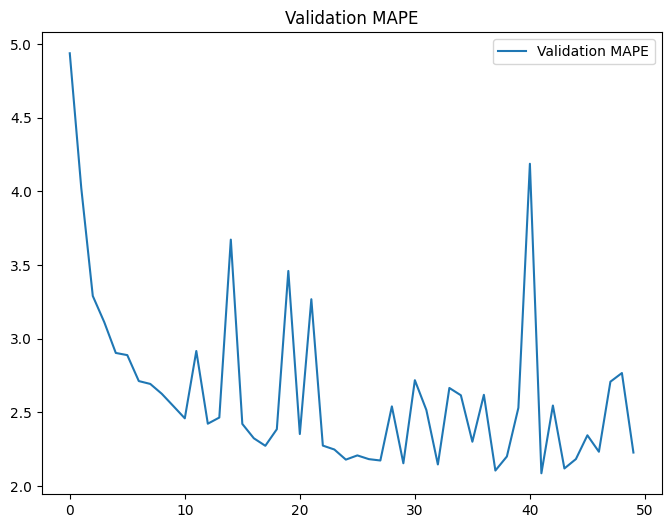

In [23]:
model_fnn_w7h1_preds_inv, model_fnn_w7h1_res = fit_eval(model_fnn, horizon=1, window=7)
model_fnn_w7h1_res

#### FNN - Window Size 7, Horizon 7

Restoring model weights from the end of the best epoch: 43.
Epoch 51: early stopping

--------------------
Evaluating model on test data...
[0.01701158471405506, 0.01701158471405506, 0.0007494526216760278, 4.037329196929932]
22/22 [==============================] - 0s 926us/step


{'mae': 1240.2366, 'mse': 3983488.5, 'rmse': 1240.2366, 'mape': 4.0100455}

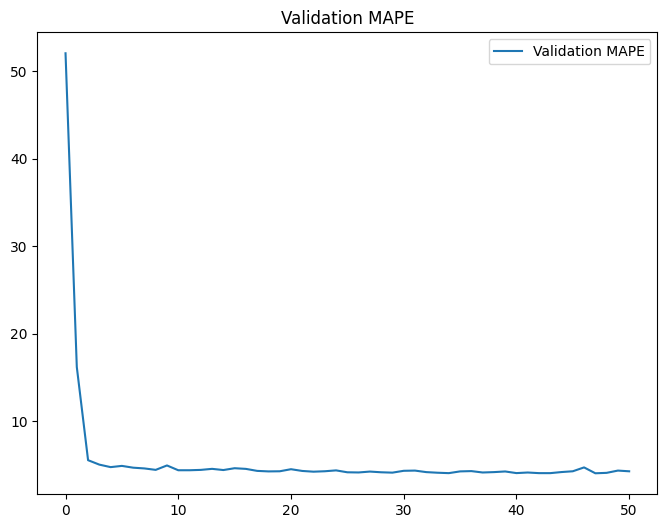

In [24]:
model_fnn_w7h7_preds_inv, model_fnn_w7h7_res = fit_eval(model_fnn, horizon=7, window=7)
model_fnn_w7h7_res

#### FNN - Window Size 30, Horizon 1

Restoring model weights from the end of the best epoch: 42.
Epoch 50: early stopping

--------------------
Evaluating model on test data...
[0.009920625016093254, 0.009920625016093254, 0.0002350762370042503, 2.3746280670166016]
22/22 [==============================] - 0s 809us/step


{'mae': 723.2671, 'mse': 1249476.4, 'rmse': 723.2671, 'mape': 2.3585496}

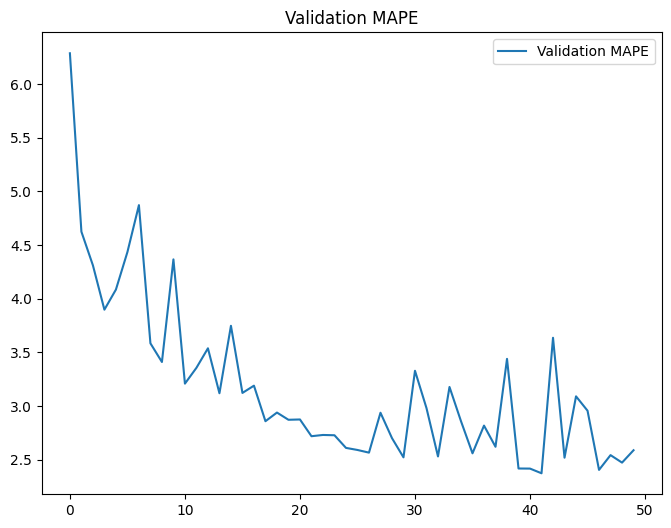

In [25]:
model_fnn_w30h1_preds_inv, model_fnn_w30h1_res = fit_eval(model_fnn, horizon=1, window=30)
model_fnn_w30h1_res

#### FNN - Window Size 30, Horizon 7

Restoring model weights from the end of the best epoch: 35.
Epoch 43: early stopping

--------------------
Evaluating model on test data...
[0.018802179023623466, 0.018802179023623466, 0.0008482214761897922, 4.4917097091674805]
22/22 [==============================] - 0s 1ms/step


{'mae': 1370.7803, 'mse': 4508464.0, 'rmse': 1370.7803, 'mape': 4.4613595}

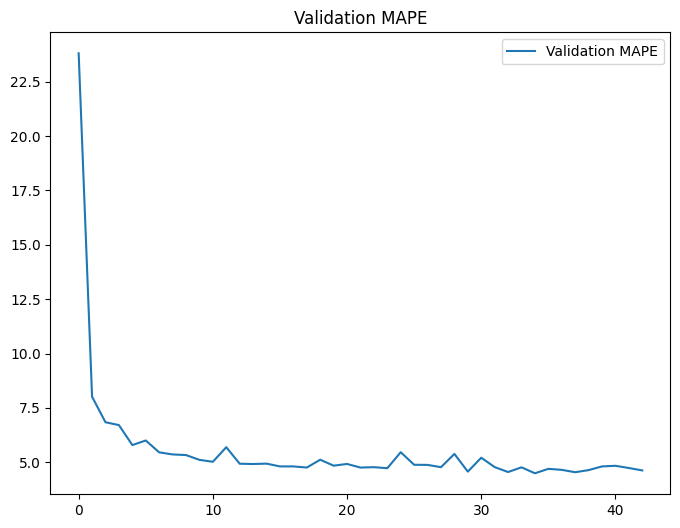

In [26]:
model_fnn_w30h7_preds_inv, model_fnn_w30h7_res = fit_eval(model_fnn, horizon=7, window=30)
model_fnn_w30h7_res

#### FNN - Window Size 90, Horizon 1

Restoring model weights from the end of the best epoch: 37.
Epoch 45: early stopping

--------------------
Evaluating model on test data...
[0.015489050187170506, 0.015489050187170506, 0.0004851568955928087, 3.9190547466278076]
22/22 [==============================] - 0s 909us/step


{'mae': 1129.2352, 'mse': 2578704.8, 'rmse': 1129.2352, 'mape': 3.891482}

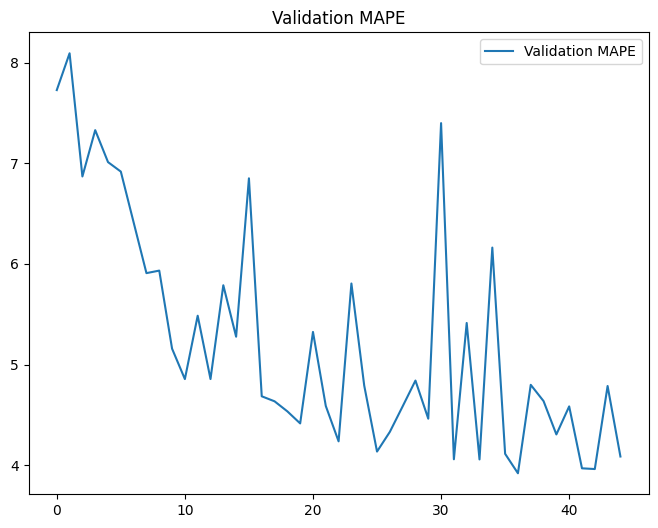

In [27]:
model_fnn_w90h1_preds_inv, model_fnn_w90h1_res = fit_eval(model_fnn, horizon=1, window=90)
model_fnn_w90h1_res

#### FNN - Window Size 90, Horizon 7

Restoring model weights from the end of the best epoch: 39.
Epoch 47: early stopping

--------------------
Evaluating model on test data...
[0.02088663913309574, 0.02088663913309574, 0.0009812641656026244, 5.03570556640625]
22/22 [==============================] - 0s 963us/step


{'mae': 1522.7489, 'mse': 5215612.0, 'rmse': 1522.7489, 'mape': 5.001249}

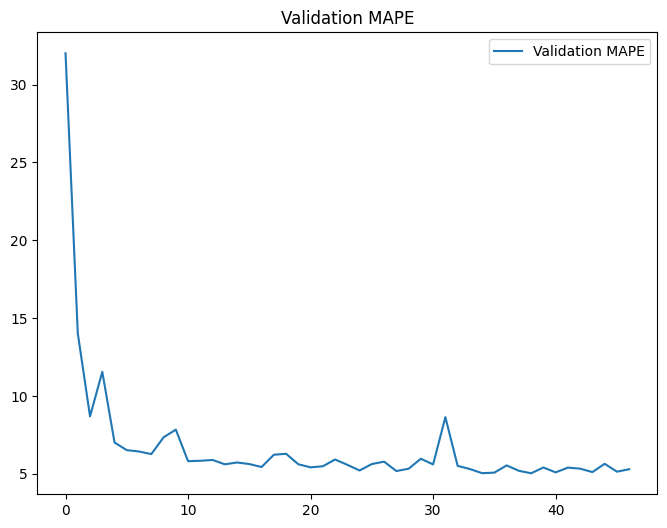

In [28]:
model_fnn_w90h7_preds_inv, model_fnn_w90h7_res = fit_eval(model_fnn, horizon=7, window=90)
model_fnn_w90h7_res

#### FNN - Window Size 90, Horizon 30

Restoring model weights from the end of the best epoch: 41.
Epoch 49: early stopping

--------------------
Evaluating model on test data...
[0.04076375812292099, 0.04076375812292099, 0.00413931580260396, 9.971261024475098]
22/22 [==============================] - 0s 840us/step


{'mae': 2971.8982, 'mse': 22001280.0, 'rmse': 2971.8982, 'mape': 9.901445}

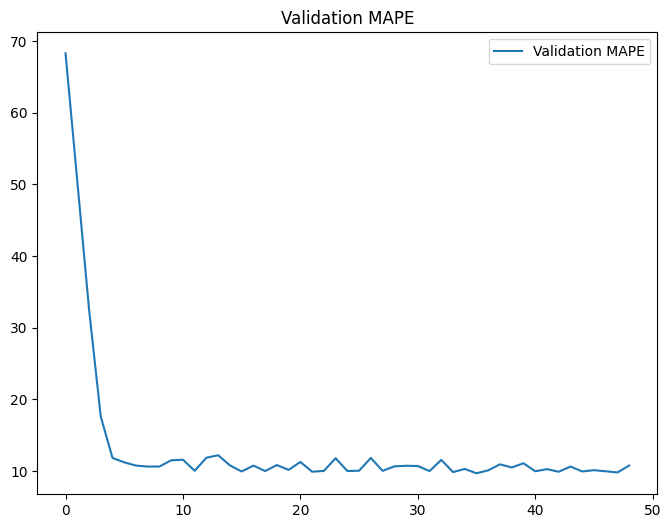

In [29]:
model_fnn_w90h30_preds_inv, model_fnn_w90h30_res = fit_eval(model_fnn, horizon=30, window=90)
model_fnn_w90h30_res

### GRU (Gated Recurrent Unit)

In [30]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.GRU(16, activation="relu")
], name="GRU")


#### GRU - Window Size 7, Horizon 1

Restoring model weights from the end of the best epoch: 54.
Epoch 62: early stopping

--------------------
Evaluating model on test data...
[0.009453430771827698, 0.009453430771827698, 0.00022449612151831388, 2.213681936264038]
22/22 [==============================] - 0s 1ms/step


{'mae': 689.2061, 'mse': 1193241.2, 'rmse': 689.2061, 'mape': 2.1988943}

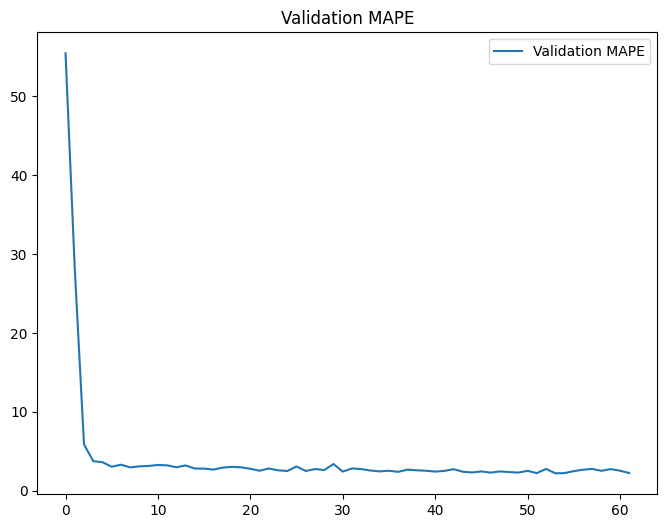

In [31]:
model_gru_w7h1_preds_inv, model_gru_w7h1_res = fit_eval(model_gru, horizon=1, window=7)
model_gru_w7h1_res

#### GRU - Window Size 7, Horizon 7

Restoring model weights from the end of the best epoch: 72.
Epoch 80: early stopping

--------------------
Evaluating model on test data...
[0.017800094559788704, 0.017800094559788704, 0.000788710662163794, 4.2362470626831055]
22/22 [==============================] - 0s 1ms/step


{'mae': 1297.723, 'mse': 4192153.5, 'rmse': 1297.723, 'mape': 4.2075405}

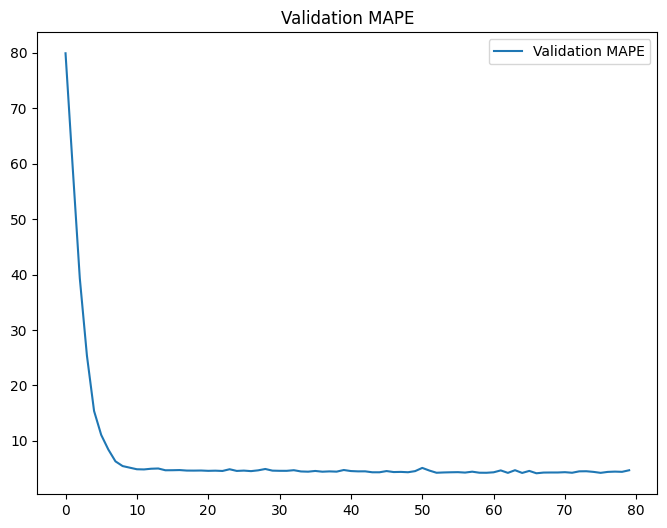

In [32]:
model_gru_w7h7_preds_inv, model_gru_w7h7_res = fit_eval(model_gru, horizon=7, window=7)
model_gru_w7h7_res

#### GRU - Window Size 30, Horizon 1

Restoring model weights from the end of the best epoch: 75.
Epoch 83: early stopping

--------------------
Evaluating model on test data...
[0.010209504514932632, 0.010209504514932632, 0.00024699498317204416, 2.4485819339752197]
22/22 [==============================] - 0s 1ms/step


{'mae': 744.32794, 'mse': 1312826.9, 'rmse': 744.32794, 'mape': 2.4318798}

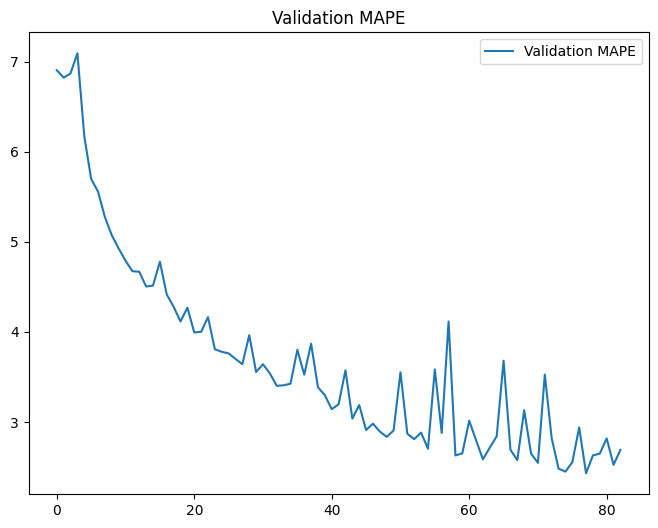

In [33]:
model_gru_w30h1_preds_inv, model_gru_w30h1_res = fit_eval(model_gru, horizon=1, window=30)
model_gru_w30h1_res

#### GRU - Window Size 30, Horizon 7

Restoring model weights from the end of the best epoch: 71.
Epoch 79: early stopping

--------------------
Evaluating model on test data...
[0.018766973167657852, 0.018766973167657852, 0.0008613918907940388, 4.493112564086914]
22/22 [==============================] - 0s 1ms/step


{'mae': 1368.2135, 'mse': 4578468.0, 'rmse': 1368.2135, 'mape': 4.462509}

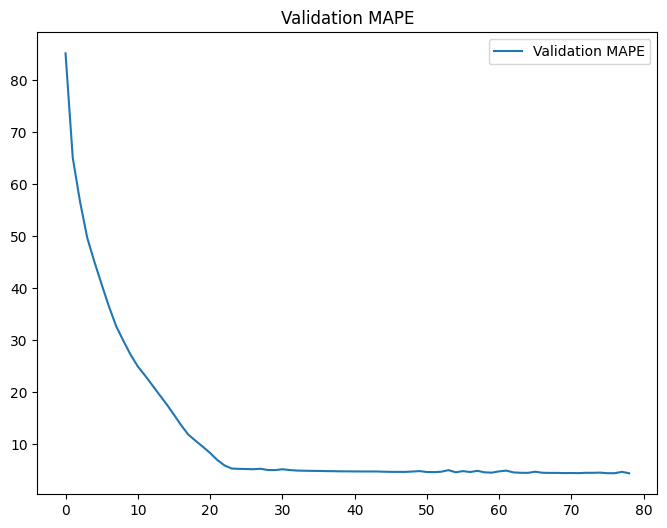

In [34]:
model_gru_w30h7_preds_inv, model_gru_w30h7_res = fit_eval(model_gru, horizon=7, window=30)
model_gru_w30h7_res

#### GRU - Window Size 90, Horizon 1

Restoring model weights from the end of the best epoch: 83.
Epoch 91: early stopping

--------------------
Evaluating model on test data...
[0.011500990018248558, 0.011500990018248558, 0.0003222235827706754, 2.736360788345337]
22/22 [==============================] - 0s 1ms/step


{'mae': 838.48425, 'mse': 1712682.1, 'rmse': 838.48425, 'mape': 2.717813}

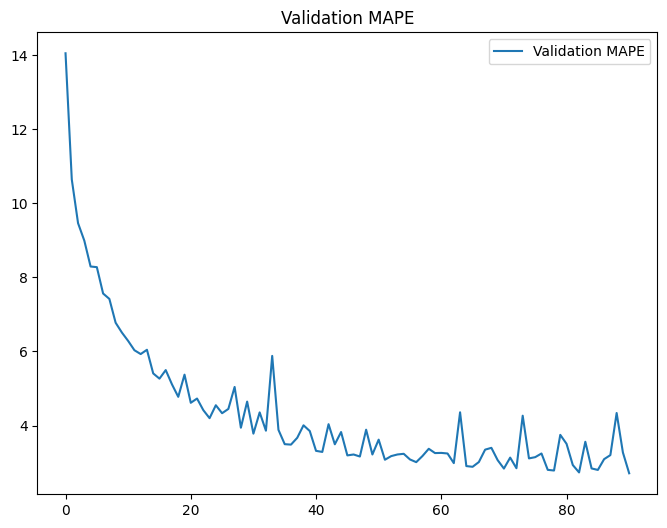

In [35]:
model_gru_w90h1_preds_inv, model_gru_w90h1_res = fit_eval(model_gru, horizon=1, window=90)
model_gru_w90h1_res

#### GRU - Window Size 90, Horizon 7

Restoring model weights from the end of the best epoch: 92.
Epoch 100: early stopping

--------------------
Evaluating model on test data...
[0.019179534167051315, 0.019179534167051315, 0.0008817247580736876, 4.6217451095581055]
22/22 [==============================] - 0s 1ms/step


{'mae': 1398.2915, 'mse': 4686541.5, 'rmse': 1398.2915, 'mape': 4.5901356}

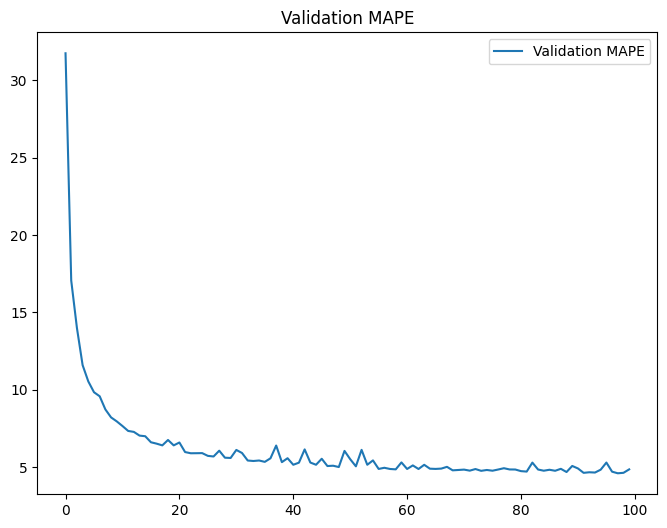

In [36]:
model_gru_w90h7_preds_inv, model_gru_w90h7_res = fit_eval(model_gru, horizon=7, window=90)
model_gru_w90h7_res

#### GRU - Window Size 90, Horizon 30

Restoring model weights from the end of the best epoch: 17.
Epoch 25: early stopping

--------------------
Evaluating model on test data...
[0.042531684041023254, 0.042531684041023254, 0.0042020464316010475, 10.359267234802246]
22/22 [==============================] - 0s 956us/step


{'mae': 3100.7893, 'mse': 22334704.0, 'rmse': 3100.7893, 'mape': 10.286997}

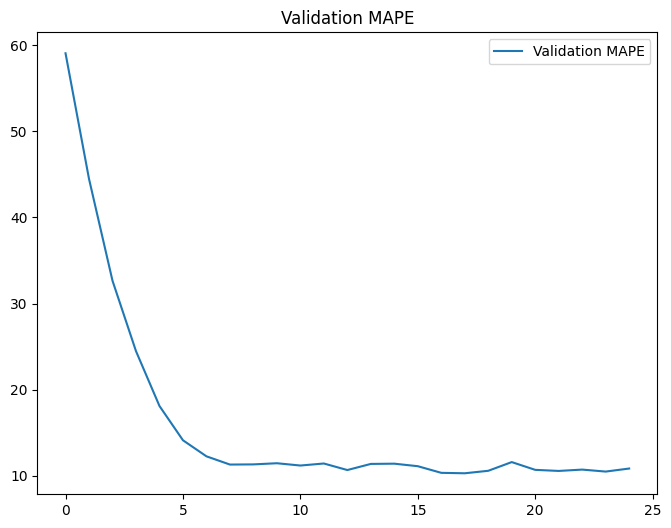

In [37]:
model_gru_w90h30_preds_inv, model_gru_w90h30_res = fit_eval(model_gru, horizon=30, window=90)
model_gru_w90h30_res

### Bidirectional GRU (Gated Recurrent Unit)

In [41]:
model_bi_gru = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(16, activation="relu"))
], name="BiGRU")


#### BiGRU - Window Size 7, Horizon 1

Restoring model weights from the end of the best epoch: 52.
Epoch 60: early stopping

--------------------
Evaluating model on test data...
[0.009217710234224796, 0.009217710234224796, 0.0002126152830896899, 2.1740880012512207]
22/22 [==============================] - 0s 1ms/step


{'mae': 672.0209, 'mse': 1130092.2, 'rmse': 672.0209, 'mape': 2.1595373}

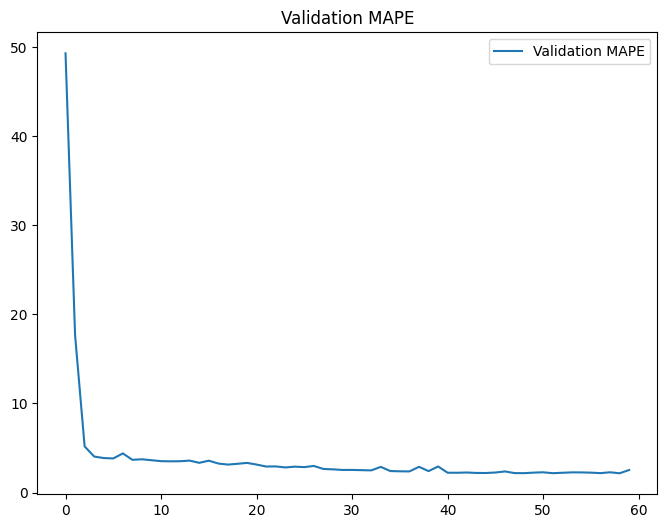

In [42]:
model_bi_gru_w7h1_preds_inv, model_bi_gru_w7h1_res = fit_eval(model_bi_gru, horizon=1, window=7)
model_bi_gru_w7h1_res 

#### BiGRU - Window Size 7, Horizon 7

Restoring model weights from the end of the best epoch: 28.
Epoch 36: early stopping

--------------------
Evaluating model on test data...
[0.020626869052648544, 0.020626869052648544, 0.001073160208761692, 4.845931529998779]
22/22 [==============================] - 0s 1ms/step


{'mae': 1503.8099, 'mse': 5704059.0, 'rmse': 1503.8099, 'mape': 4.813354}

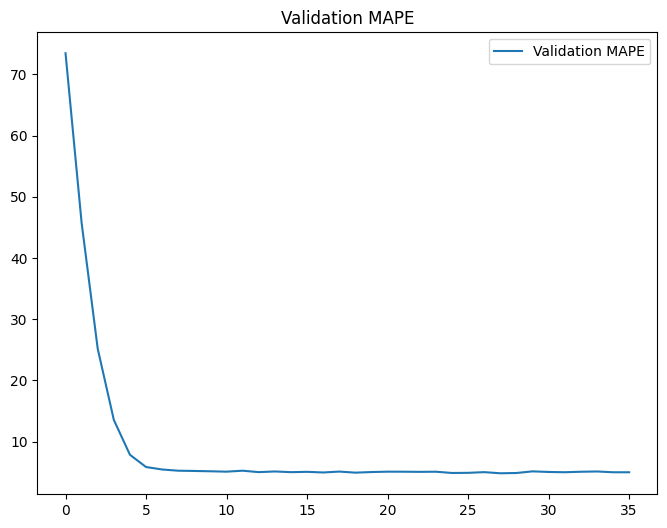

In [43]:
model_bi_gru_w7h7_preds_inv, model_bi_gru_w7h7_res = fit_eval(model_bi_gru, horizon=7, window=7)
model_bi_gru_w7h7_res

#### BiGRU - Window Size 30, Horizon 1

Restoring model weights from the end of the best epoch: 84.
Epoch 92: early stopping

--------------------
Evaluating model on test data...
[0.009640210308134556, 0.009640210308134556, 0.0002406021230854094, 2.230515956878662]
22/22 [==============================] - 0s 2ms/step


{'mae': 702.8235, 'mse': 1278847.9, 'rmse': 702.8235, 'mape': 2.215623}

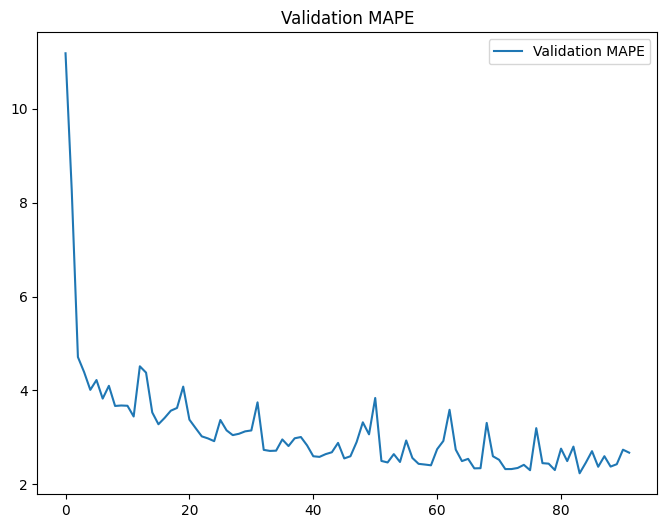

In [44]:
model_bi_gru_w30h1_preds_inv, model_bi_gru_w30h1_res = fit_eval(model_bi_gru, horizon=1, window=30)
model_bi_gru_w30h1_res

#### BiGRU - Window Size 30, Horizon 7

Restoring model weights from the end of the best epoch: 38.
Epoch 46: early stopping

--------------------
Evaluating model on test data...
[0.01967998966574669, 0.01967998966574669, 0.0009704226977191865, 4.63945198059082]
22/22 [==============================] - 0s 2ms/step


{'mae': 1434.7775, 'mse': 5157987.5, 'rmse': 1434.7775, 'mape': 4.6080594}

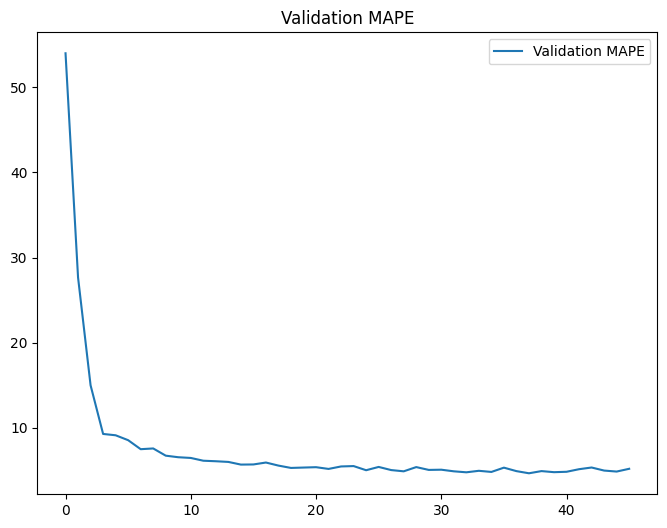

In [45]:
model_bi_gru_w30h7_preds_inv, model_bi_gru_w30h7_res = fit_eval(model_bi_gru, horizon=7, window=30)
model_bi_gru_w30h7_res

#### BiGRU - Window Size 90, Horizon 1

Restoring model weights from the end of the best epoch: 66.
Epoch 74: early stopping

--------------------
Evaluating model on test data...
[0.011448248289525509, 0.011448248289525509, 0.00031127603142522275, 2.7222580909729004]
22/22 [==============================] - 0s 1ms/step


{'mae': 834.6391, 'mse': 1654493.4, 'rmse': 834.6391, 'mape': 2.7037144}

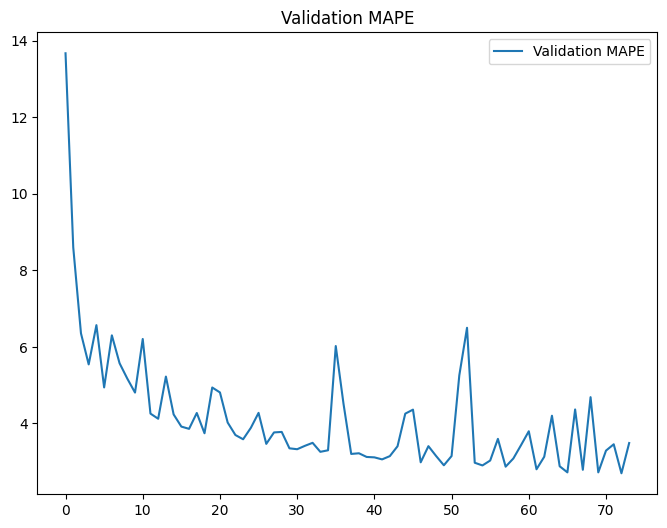

In [46]:
model_bi_gru_w90h1_preds_inv, model_bi_gru_w90h1_res = fit_eval(model_bi_gru, horizon=1, window=90)
model_bi_gru_w90h1_res

#### BiGRU - Window Size 90, Horizon 7

Restoring model weights from the end of the best epoch: 65.
Epoch 73: early stopping

--------------------
Evaluating model on test data...
[0.020083574578166008, 0.020083574578166008, 0.0010042728390544653, 4.783844947814941]
22/22 [==============================] - 0s 1ms/step


{'mae': 1464.201, 'mse': 5337908.0, 'rmse': 1464.201, 'mape': 4.7513056}

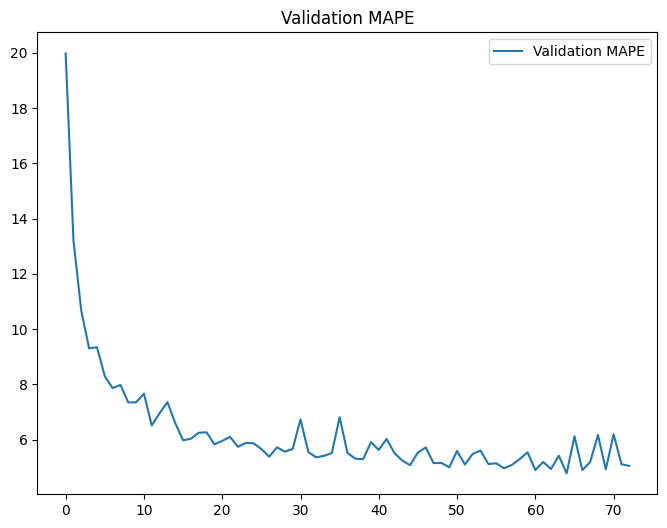

In [47]:
model_bi_gru_w90h7_preds_inv, model_bi_gru_w90h7_res = fit_eval(model_bi_gru, horizon=7, window=90)
model_bi_gru_w90h7_res

#### BiGRU - Window Size 90, Horizon 30


Restoring model weights from the end of the best epoch: 26.
Epoch 34: early stopping

--------------------
Evaluating model on test data...
[0.04203179478645325, 0.04203179478645325, 0.004301130771636963, 10.321052551269531]
22/22 [==============================] - 0s 1ms/step


{'mae': 3064.3445, 'mse': 22861356.0, 'rmse': 3064.3445, 'mape': 10.248369}

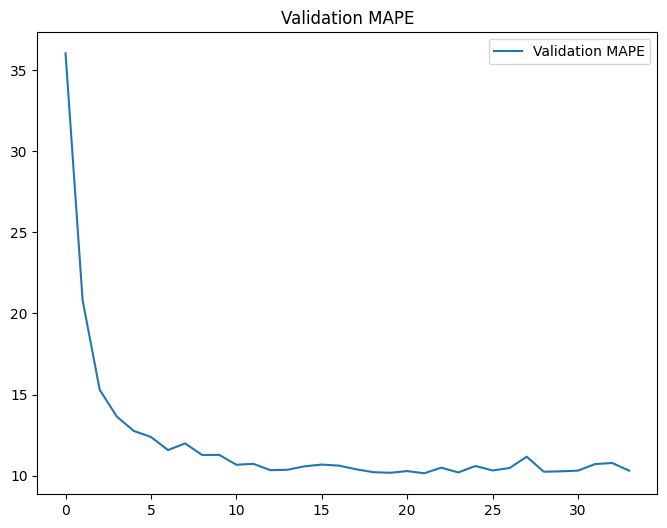

In [48]:
model_bi_gru_w90h30_preds_inv, model_bi_gru_w90h30_res = fit_eval(model_bi_gru, horizon=30, window=90)
model_bi_gru_w90h30_res